In [7]:
import requests
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True

In [8]:
df = pd.read_pickle('../dataset/preprocessed/group_imputed.pkl')

In [9]:
# only select final occupancy
df = df[df['DBA']==89]
df = df.rename(columns={'ROH_med':'ROH'})
# # timeserise only on ROH
df = df.drop(columns=['DBA','ROH_min','ROH_max','ROH_avg','ROH_std','DOW','LAR_max','LAR_min','LAR_med','LAR_avg','LAR_std'])
df = df.set_index('DOA')
# # Filling missing values
df = df.asfreq(freq='d', method='ffill')
df.loc[df['ROH']==0,'ROH'] = df['ROH'].median()
## normalizing
scaler = MinMaxScaler()
df['ROH'] = scaler.fit_transform(df)

In [10]:
df.head()

HotelId,ROH
DOA,
2018-01-01,0.264706
2018-01-02,0.286765
2018-01-03,0.294118
2018-01-04,0.213235
2018-01-05,0.191176


In [11]:
index = int(len(df)*0.8)
train = df[:index]
test  = df[index:]

In [12]:
df.head()

HotelId,ROH
DOA,
2018-01-01,0.264706
2018-01-02,0.286765
2018-01-03,0.294118
2018-01-04,0.213235
2018-01-05,0.191176


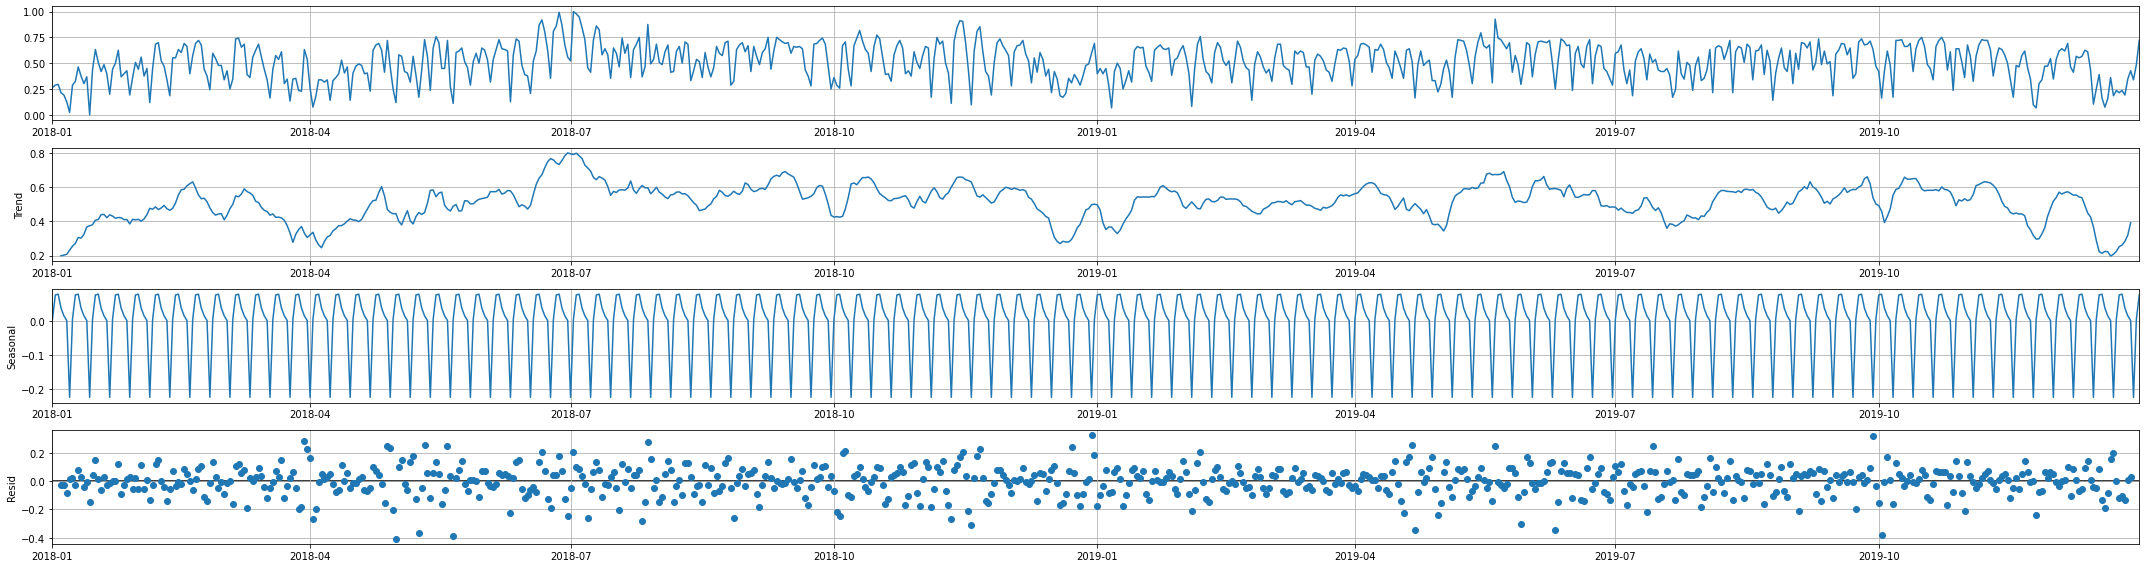

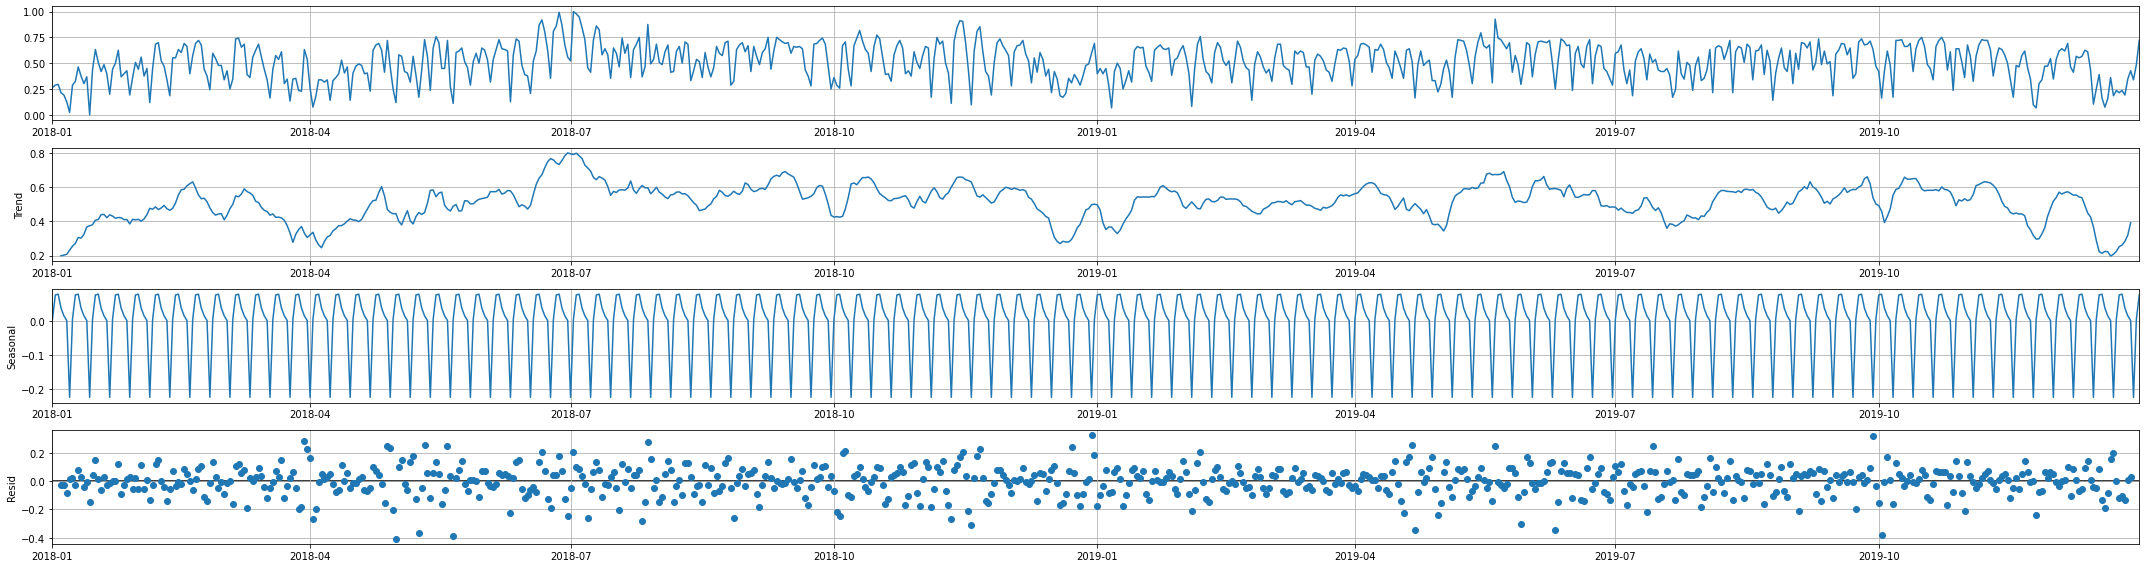

In [13]:
fig = sm.tsa.seasonal_decompose(df)
fig.plot()

In [14]:
def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df.ROH, label='raw data')
    ax[0].plot(df.ROH.rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df.ROH.rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

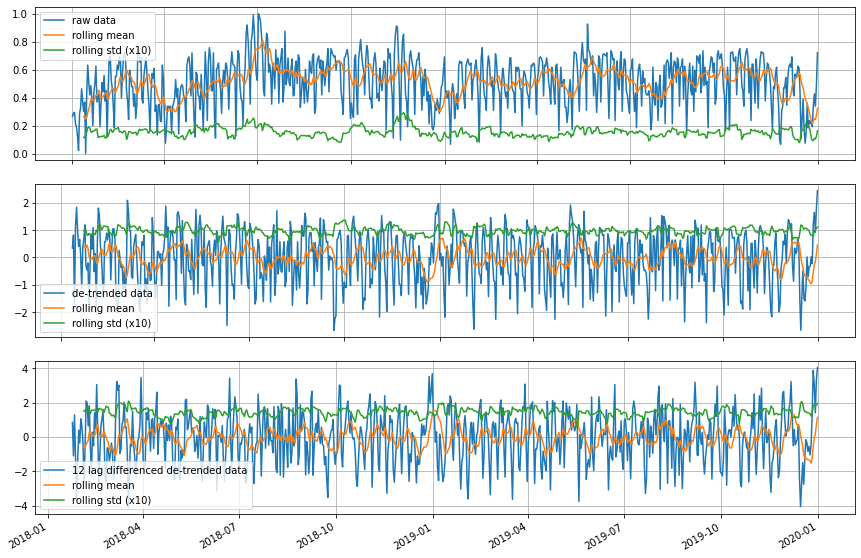

In [15]:
df['z_data'] = (df['ROH'] - df.ROH.rolling(window=12).mean()) / df.ROH.rolling(window=12).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(12)

plot_rolling(df)

## Augmented Dickey-Fuller Test

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
print(" > Is the data stationary ?")
dftest = adfuller(df.ROH, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -3.679
P-value = 0.004
Critical values :
	1%: -3.439606888036868 - The data is  stationary with 99% confidence
	5%: -2.865625121924057 - The data is  stationary with 95% confidence
	10%: -2.5689454046801052 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -7.026
P-value = 0.000
Critical values :
	1%: -3.439753311961436 - The data is  stationary with 99% confidence
	5%: -2.8656896390914217 - The data is  stationary with 95% confidence
	10%: -2.568979777013325 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -10.954
P-value = 0.000
Critical values :
	1%: -3.4398489271901713 - The data is  stationary with 99% confidence
	5%: -2.8657317673059395 - The data is  stationary with 95% confidence
	10%: -2.569002221596252 - The data is  stationary with 90% confidence


## Autocorrelation plots (ACF & PACF)

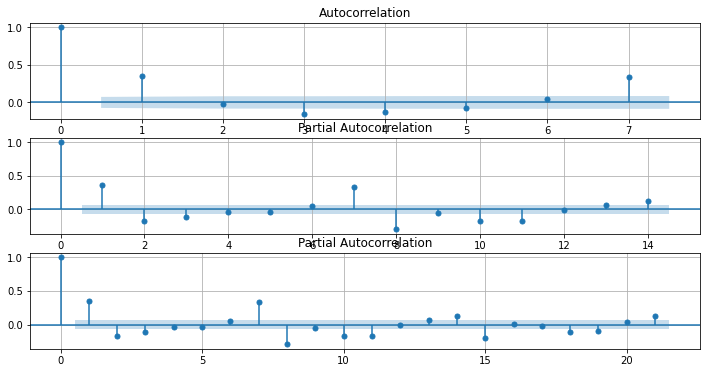

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(3, figsize=(12,6))
ax[0] = plot_acf(df.z_data.dropna(), ax=ax[0], lags=7)
ax[1] = plot_pacf(df.z_data.dropna(), ax=ax[1], lags=14)
ax[2] = plot_pacf(df.z_data.dropna(), ax=ax[2], lags=21)

## Simple Explonential Smoothing

In [19]:
SES_model = SimpleExpSmoothing(train['ROH'].values)
SES_model._index = pd.to_datetime(train.index)

fit1 = SES_model.fit()
fit2 = SES_model.fit(smoothing_level=.2)
fit3 = SES_model.fit(smoothing_level=.5)

pred1 = fit1.forecast(146)
pred2 = fit2.forecast(146)
pred3 = fit3.forecast(146)

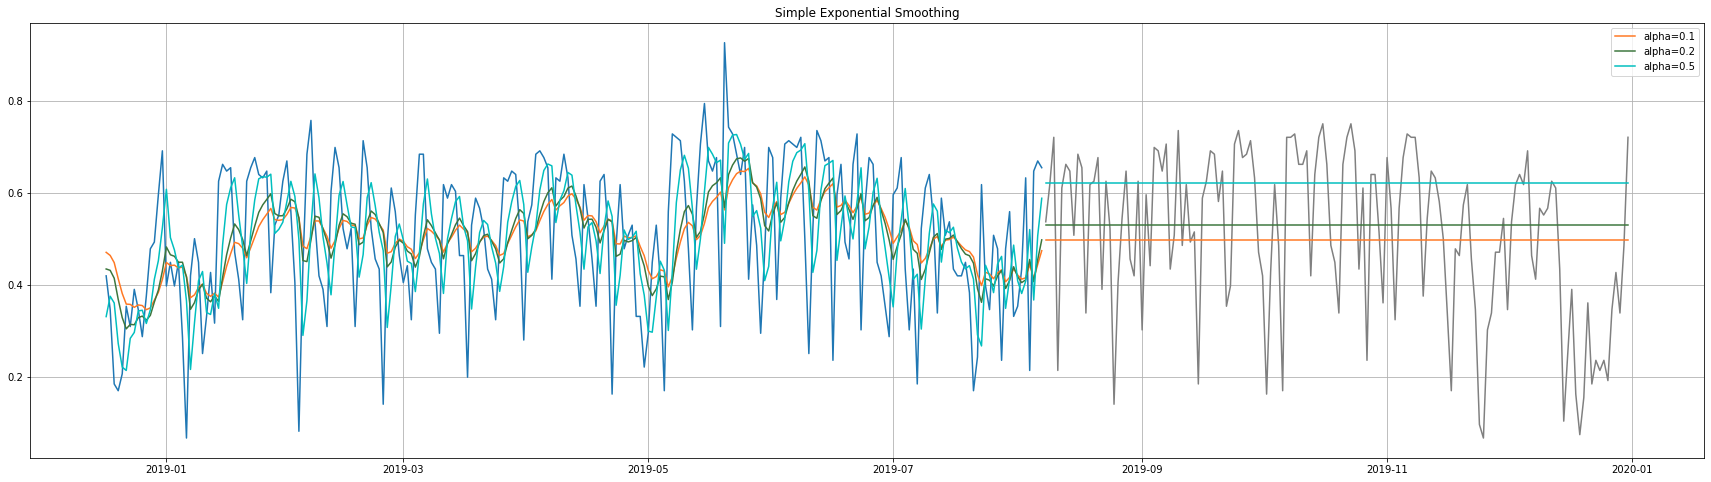

In [20]:
fig, ax = plt.subplots()
ax.plot(train.index[350:], train.values[350:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[350:], f.fittedvalues[350:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend()

## Holt's method

In [21]:
HOLT_model = Holt(train['ROH'].values)
HOLT_model._index = pd.to_datetime(train.index)

fit1 = HOLT_model.fit(smoothing_level=.3, smoothing_slope=.05)
fit2 = HOLT_model.fit(optimized=True)
fit3 = HOLT_model.fit(smoothing_level=.3, smoothing_slope=.2)

pred1 = fit1.forecast(146)
pred2 = fit2.forecast(146)
pred3 = fit3.forecast(146)

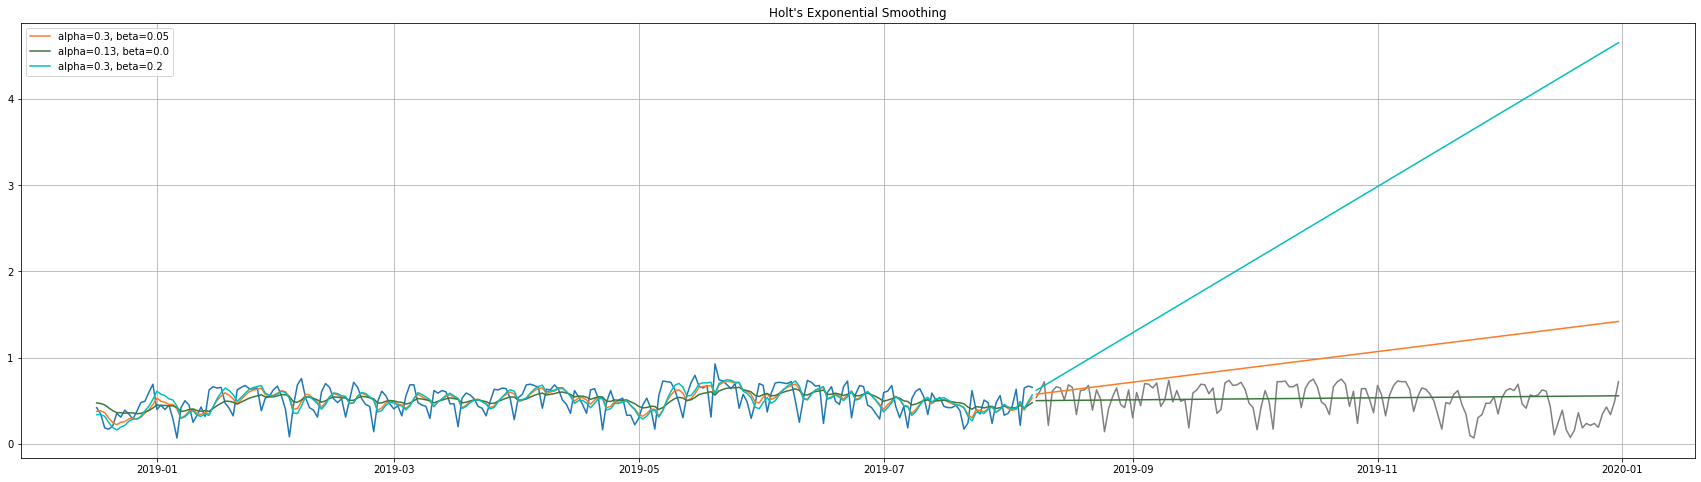

In [22]:
fig, ax = plt.subplots()
ax.plot(train.index[350:], train.values[350:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[350:], f.fittedvalues[350:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend()


## Exponential smoothing 

In [23]:
ES_model = ExponentialSmoothing(train['ROH'].values, trend='add', seasonal=None)
ES_model2 = ExponentialSmoothing(train['ROH'].values, trend='add', seasonal=None, damped=True)
ES_model._index = pd.to_datetime(train.index)

fit1 = ES_model.fit()
fit2 = ES_model2.fit()

pred1 = fit1.forecast(146)
pred2 = fit2.forecast(146)

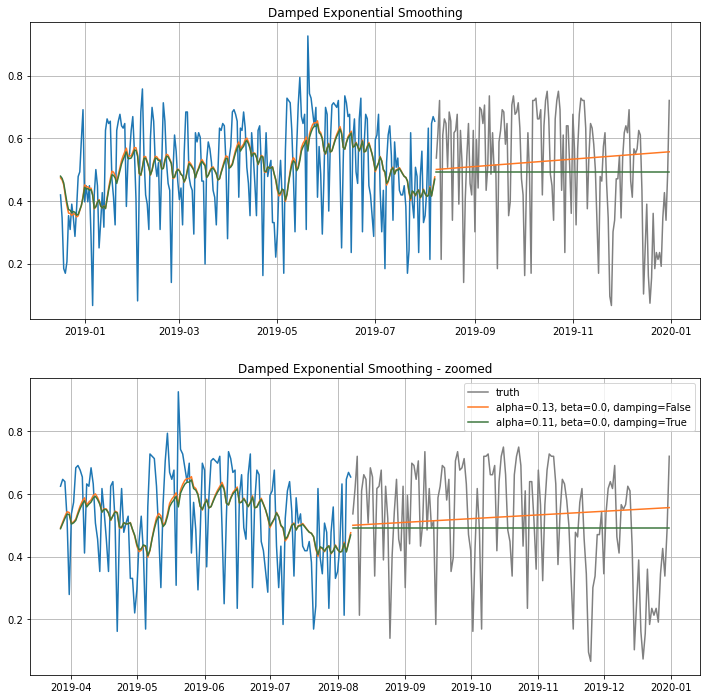

In [24]:
fig, ax = plt.subplots(2, figsize=(12, 12))
ax[0].plot(train.index[350:], train.values[350:])
ax[0].plot(test.index, test.values, color="gray", label="truth")
ax[1].plot(train.index[450:], train.values[450:])
ax[1].plot(test.index, test.values, color="gray", label="truth")
for p, f, c in zip((pred1, pred2),(fit1, fit2),('#ff7823','#3c763d')):
    ax[0].plot(train.index[350:], f.fittedvalues[350:], color=c)
    ax[1].plot(train.index[450:], f.fittedvalues[450:], color=c)
    ax[0].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
    ax[1].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
ax[0].set_title("Damped Exponential Smoothing");
ax[1].set_title("Damped Exponential Smoothing - zoomed");
plt.legend();

In [25]:
model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=7)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=7, damped=True)


fit = model.fit()
fit2 = model2.fit()
pred = fit.forecast(146)
pred2 = fit2.forecast(146)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))

Text(0.5, 1.0, "Holt-Winter's Seasonal Smoothing")

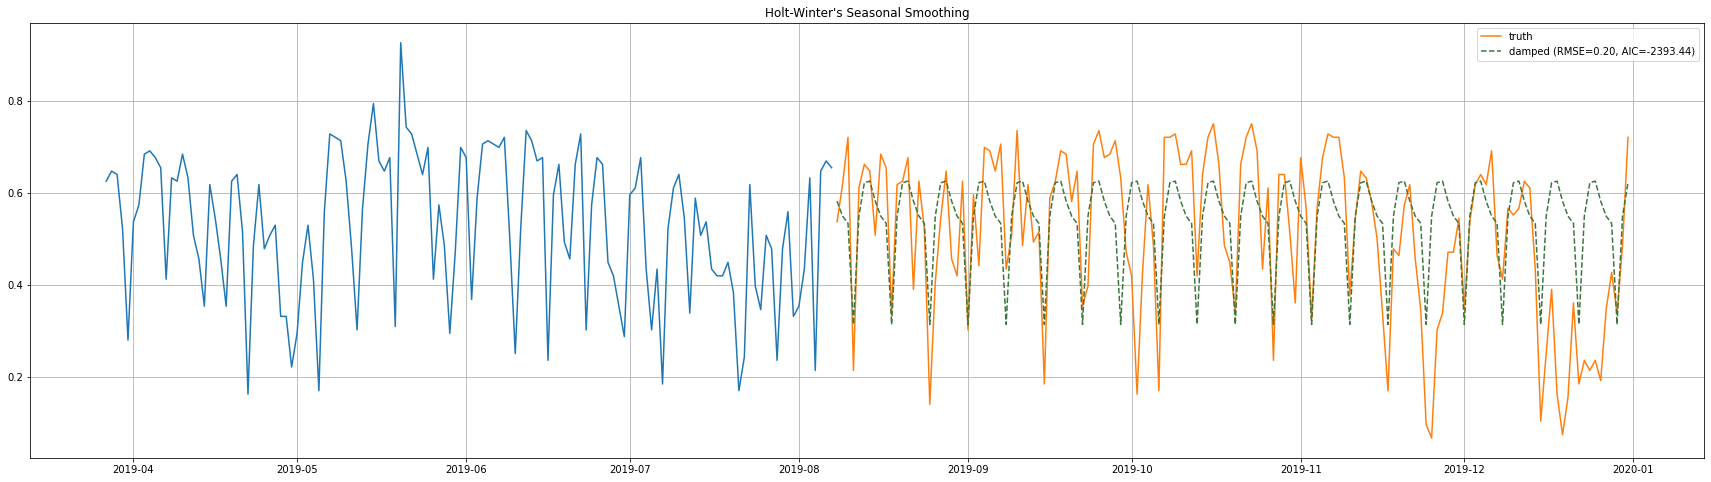

In [26]:
fig, ax = plt.subplots()
ax.plot(train.index[450:], train.values[450:])
ax.plot(test.index, test.values, label='truth')
# ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic))
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)) 
ax.legend()
ax.set_title("Holt-Winter's Seasonal Smoothing")

In [27]:
rmse = mean_squared_error(test['ROH'].values, pred2, squared=False)
mape = np.mean(np.abs((pred2-test['ROH'].values)/test['ROH'].values))

In [29]:
mape

0.4315916988439468

In [45]:
df

HotelId,ROH,z_data,zp_data
DOA,,,
2018-01-01,60.5,NaN,NaN
2018-01-02,62.0,NaN,NaN
2018-01-03,62.5,NaN,NaN
2018-01-04,57.0,NaN,NaN
2018-01-05,55.5,NaN,NaN
...,...,...,...
2019-12-27,66.0,1.213356,3.877800
2019-12-28,71.5,1.648520,3.055459
2019-12-29,65.5,0.919444,1.406938


array([[0.26470588,        nan,        nan],
       [0.28676471,        nan,        nan],
       [0.29411765,        nan,        nan],
       ...,
       [0.33823529, 0.70209925, 0.67648187],
       [0.48529412, 0.87044509, 0.90943887],
       [0.72058824, 1.        , 1.        ]])